In [1]:
%matplotlib ipympl

In [2]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
SS_VER = 'SS_VER_1_1'
ALGORITHM = 'shiffthq' # mbedtls or shiffthq

In [3]:
%%bash -s "$PLATFORM" "$SS_VER" "$ALGORITHM" 
cd ../
make PLATFORM=$1 SS_VER=$2 ALGO=$3 -j

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
make[1]: '.dep' is up to date.
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:10.3-2021.07-4) 10.3.1 20210621 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling:
-en     shiffthq.c ...
-e Done!
.
Assembling: .././hal/stm32f3/stm32f3_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -DF_CPU=7372800 -Wa,-gstabs,-adhlns=objdir-CWLITEARM/stm32f3_startup.lst -I./lib/shiffthq/src -I./include -I.././simpleserial/ -I.././hal -I.././hal/stm32f3 -I.././hal/stm32f3/CMSIS -I.././hal/stm32f3/CMSIS/core -I.././hal/stm32f3/CMSIS/device -I.././hal/stm32f4/Legacy -I.

In [4]:
import chipwhisperer as cw
import time
import matplotlib.pylab as plt
from tqdm.notebook import trange
import numpy as np
import time

In [5]:
# try to disconnect if we already have a scope inside this kernel.
try:
    scope.dis()
    target.dis()
except:
    pass

In [6]:
def flash(algorithm: str):
    if algorithm in ["mbedtls", "shiffthq"]:
        cw.program_target(scope, cw.programmers.STM32FProgrammer, f"../ss-chacha20-{algorithm}-{PLATFORM}.hex")
    else:
        raise FileNotFoundError(f"The algorithm {algorithm} is not one of mbedtls, shiffthq")

In [7]:
%run "../setup/setup.ipynb"

# Reset Scope
reset_target(scope)

# MBEDTLS
flash(ALGORITHM)

# flush possible work
target.flush()
scope.arm()

# Write counter & nonce
nonce = bytearray(b'\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\xaa')
target.simpleserial_write('p', nonce, end='\n')

# Capture
ret = scope.capture()
# if ret:
#       raise TimeoutError('Timeout happened during acquisition')

trace = scope.get_last_trace()
print("Trace:")
print(trace)
print("")

encrypted = target.simpleserial_read('r', 64)
print("Decoded encrypted value:")
for byte in encrypted:
    print(f'{byte:02x}', end=' ')

(ChipWhisperer NAEUSB WARNING|File naeusb.py:802) Your firmware (0.64) is outdated - latest is 0.65 See https://chipwhisperer.readthedocs.io/en/latest/firmware.html for more information


INFO: Found ChipWhisperer😍
scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.samples                        changed from 24400                     to 5000                     
scope.adc.trig_count                     changed from 2224131769                to 2236199208               
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.clkgen_div                   changed from 1                         to 26                       
scope.clock.clkgen_freq                  changed from 192000000.0               to 7384615.384615385 

(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:730) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:730) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


Trace:
[-0.00683594 -0.1640625  -0.08886719 ... -0.15039062 -0.08007812
 -0.05566406]

Decoded encrypted value:
f0 af 4a 68 a9 6d ba d5 e6 36 e9 02 c6 e3 9b 89 43 26 1c 5f c3 1d ef a1 a4 bf c0 3b d6 ec 10 3b d1 76 ab 9b c0 3a 14 8c fd 84 ec 95 ab e5 af 45 75 1e ed 8a df 96 6b 7c 31 86 a3 48 16 86 32 9e 

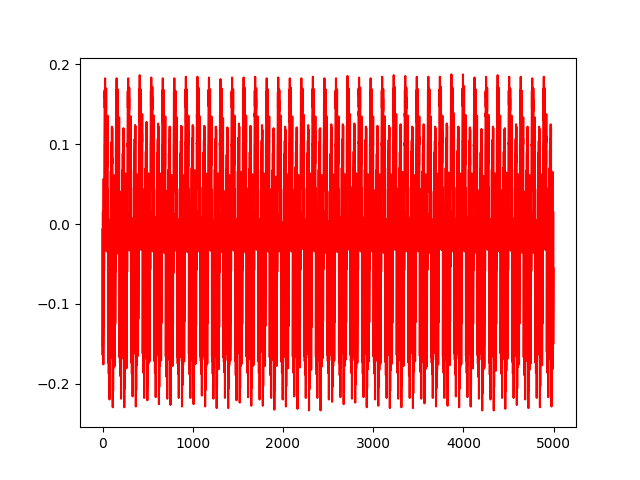

In [8]:
plt.figure()
plt.plot(trace, 'r')
plt.show()

In [9]:
def run_many_traces(ntraces: int):
    trace_array = []
    nc_array = []
    
    ktp = cw.ktp.Basic()
    _, nc = ktp.next()
    
    start_time = time.time()
    for i in trange(ntraces, desc="Capturing " + str(ntraces) + " traces"):
        scope.arm()
        target.simpleserial_write('p', nc, end='\n')
        ret = scope.capture()
        # if ret:
        #         print('Timeout happened during acquisition')
        encrypted = target.simpleserial_read('r', 64)
        trace_array.append(scope.get_last_trace())
        nc_array.append(nc)
        _, nc = ktp.next()
        
    trace_array = np.array(trace_array)
    nc_array = np.array(nc_array)
    print("--- %s ---" % (time.time() - start_time))
    np.save(f'trace{ntraces}-{ALGORITHM}.npy', trace_array)
    np.save(f'nonce{ntraces}-{ALGORITHM}.npy', nc_array)

    return trace_array, nc_array

In [ ]:
run_many_traces(500)

Capturing 500 traces:   0%|          | 0/500 [00:00<?, ?it/s]

(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:730) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:730) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:730) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:730) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:730) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:730) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:730) Timeout in OpenADC capture(), no t

In [ ]:
run_many_traces(1000)

In [ ]:
run_many_traces(1500)

In [ ]:
run_many_traces(2000)